In [47]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [65]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime as dt
import glob
import seaborn as sns
import re
from collections import Counter
import os
import io
from scipy.stats import boxcox
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Loading the Dataset

In [67]:
df = pd.read_csv('US_Accidents_Dec21_updated.csv')
df.head(3)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.86542,-84.06280,39.86501,-84.04873,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10266,-84.52468,39.10209,-84.52396,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day


In [68]:
print(df.shape)
print(df.columns)

(2845342, 47)
Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


# Data Cleaning

## Handling columns with large amount of empty values

In [69]:
df.isna().sum()

ID                             0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                        0
End_Lng                        0
Distance(mi)                   0
Description                    0
Number                   1743911
Street                         2
Side                           0
City                         137
County                         0
State                          0
Zipcode                     1319
Country                        0
Timezone                    3659
Airport_Code                9549
Weather_Timestamp          50736
Temperature(F)             69274
Wind_Chill(F)             469643
Humidity(%)                73092
Pressure(in)               59200
Visibility(mi)             70546
Wind_Direction             73775
Wind_Speed(mph)           157944
Precipitation(in)         549458
Weather_Condition          70636
Amenity   

Dropping columns that have large number of null values and columns that do not make sense in predicting the probability of an accident

In [70]:
df.drop(['ID','Description','Number','Street', 'County', 'Zipcode', 'Airport_Code','Weather_Timestamp', 'End_Time', 
              'End_Lat', 'End_Lng',"Wind_Chill(F)","Wind_Speed(mph)", 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',], axis=1, inplace=True)

In [71]:
df.head(3)

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Side,City,State,Country,Timezone,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
0,3,2016-02-08 00:37:08,40.10891,-83.09286,3.230,R,Dublin,OH,US,US/Eastern,...,False,False,False,False,False,False,False,False,False,Night
1,2,2016-02-08 05:56:20,39.86542,-84.06280,0.747,R,Dayton,OH,US,US/Eastern,...,False,False,False,False,False,False,False,False,False,Night
2,2,2016-02-08 06:15:39,39.10266,-84.52468,0.055,R,Cincinnati,OH,US,US/Eastern,...,True,False,False,False,False,False,False,False,False,Night


In [72]:
df.isna().sum()

Severity                  0
Start_Time                0
Start_Lat                 0
Start_Lng                 0
Distance(mi)              0
Side                      0
City                    137
State                     0
Country                   0
Timezone               3659
Temperature(F)        69274
Humidity(%)           73092
Pressure(in)          59200
Visibility(mi)        70546
Wind_Direction        73775
Precipitation(in)    549458
Weather_Condition     70636
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Turning_Loop              0
Sunrise_Sunset         2867
dtype: int64

In [73]:
cat_names = ['Country', 'Timezone', 'Bump', 'Crossing', 
             'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 
             'Stop', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']
print("Unique count of categorical features:")
for i in cat_names:
    print(i,df[i].unique().size)

Unique count of categorical features:
Country 1
Timezone 5
Bump 2
Crossing 2
Junction 2
No_Exit 2
Railway 2
Roundabout 2
Station 2
Stop 2
Traffic_Signal 2
Turning_Loop 1
Sunrise_Sunset 3


Dropping Country & Turning_Loop since they only have one class

In [74]:
df.drop(['Country','Turning_Loop'], axis=1, inplace=True)

<a id="1.4"></a>
## 1.4 Clean Up Categorical Features
If we look at categorical features closely, we will find some chaos in 'Wind_Direction' and 'Weather_Condition'. It is necessary to clean them up first.

### Wind Direction

In [75]:
print("Wind Direction: ", df['Wind_Direction'].unique())

Wind Direction:  ['SW' 'Calm' 'WSW' 'WNW' 'West' 'NNW' 'South' 'W' 'NW' 'North' 'SSE' 'SSW'
 'ESE' 'SE' nan 'East' 'Variable' 'NNE' 'NE' 'ENE' 'CALM' 'S' 'VAR' 'N'
 'E']


Simplify wind direction

In [76]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'CALM' 'W' 'N' 'S' 'NW' 'E' 'SE' nan 'VAR' 'NE']


### Weather Condition
Weather-related vehicle accidents kill more people annually than large-scale weather disasters(source: weather.com). According to Road Weather Management Program, most weather-related crashes happen on wet-pavement and during rainfall. Winter-condition and fog are another two main reasons for weather-related accidents. To extract these three weather conditions, we first look at what we have in 'Weather_Condition' Feature.


In [77]:
# show distinctive weather conditions 
weather ='!'.join(df['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drifting Snow', 'Drizzle', 'Dust', 'Dust Whirls', 'Dust Whirls Nearby', 'Dust Whirlwinds', 'Duststorm', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain Shower', 'Heavy Rain Showers', 'Heavy Sleet', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Fog', 'Light Haze', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Shower', 'Light Snow Showers', 'Light Thunderstorms', 'Low Drifting Snow', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Snow Grains', 'Snow Nearby', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Volcanic

Create features for some common weather conditions and drop 'Weather_Condition' then.

In [78]:
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear', case=False, na = False), True, False)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), True, False)
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Rain|storm', case=False, na = False), True, False)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), True, False)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), True, False)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na = False), True, False)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog', case=False, na = False), True, False)

In [79]:
df.drop(['Weather_Condition'], axis=1, inplace=True)

<a id="1.5"></a>
## 1.5 Fix Datetime Format

Mapping 'Start_Time' to 'Year', 'Month', 'Weekday', 'Day' (in a year), 'Hour', and 'Minute' (in a day).

In [80]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Year'] = df['Start_Time'].dt.year

nmonth = df['Start_Time'].dt.month
df['Month'] = nmonth

df['Weekday']= df['Start_Time'].dt.weekday

days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in nmonth.values]
nday = nday + df["Start_Time"].dt.day.values
df['Day'] = nday

df['Hour'] = df['Start_Time'].dt.hour

df['Minute']=df['Hour']*60.0+df["Start_Time"].dt.minute

df.loc[:4,['Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']]

,Start_Time,Year,Month,Weekday,Day,Hour,Minute
0,2016-02-08 00:37:08,2016,2,0,39,0,37.0
1,2016-02-08 05:56:20,2016,2,0,39,5,356.0
2,2016-02-08 06:15:39,2016,2,0,39,6,375.0
3,2016-02-08 06:51:45,2016,2,0,39,6,411.0
4,2016-02-08 07:53:43,2016,2,0,39,7,473.0


In [81]:
df.drop(['Start_Time'], axis=1, inplace=True)

In [82]:
df.head(3)

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,City,State,Timezone,Temperature(F),Humidity(%),...,Heavy_Rain,Snow,Heavy_Snow,Fog,Year,Month,Weekday,Day,Hour,Minute
0,3,40.10891,-83.09286,3.230,R,Dublin,OH,US/Eastern,42.1,58.0,...,False,False,False,False,2016,2,0,39,0,37.0
1,2,39.86542,-84.06280,0.747,R,Dayton,OH,US/Eastern,36.9,91.0,...,False,False,False,False,2016,2,0,39,5,356.0
2,2,39.10266,-84.52468,0.055,R,Cincinnati,OH,US/Eastern,36.0,97.0,...,False,False,False,False,2016,2,0,39,6,375.0


Replacing the nan values in Precipitation(in) with the median value

In [85]:
df['Precipitation(in)'].head(5)

0    0.00
1    0.02
2    0.02
3     NaN
4    0.01
Name: Precipitation(in), dtype: float64

In [86]:
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
df['Precipitation(in)'].head(5)

0    0.00
1    0.02
2    0.02
3    0.00
4    0.01
Name: Precipitation(in), dtype: float64

In [26]:
df.isna().sum()

Severity                 0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Side                     0
City                   137
State                    0
Timezone              3659
Temperature(F)       69274
Humidity(%)          73092
Pressure(in)         59200
Visibility(mi)       70546
Wind_Direction       73775
Precipitation(in)        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Sunrise_Sunset        2867
Clear                    0
Cloud                    0
Rain                     0
Heavy_Rain               0
Snow                     0
Heavy_Snow               0
Fog                      0
Year                     0
Month                    0
Weekday                  0
D

In [27]:
df.dropna(inplace=True)

In [28]:
df.isna().any().any()

False

In [29]:
df.shape

(2740516, 40)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2740516 entries, 0 to 2845341
Data columns (total 40 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Side               object 
 5   City               object 
 6   State              object 
 7   Timezone           object 
 8   Temperature(F)     float64
 9   Humidity(%)        float64
 10  Pressure(in)       float64
 11  Visibility(mi)     float64
 12  Wind_Direction     object 
 13  Precipitation(in)  float64
 14  Amenity            bool   
 15  Bump               bool   
 16  Crossing           bool   
 17  Give_Way           bool   
 18  Junction           bool   
 19  No_Exit            bool   
 20  Railway            bool   
 21  Roundabout         bool   
 22  Station            bool   
 23  Stop               bool   
 24  Traffic_Calming    bool   
 25  Traffic_Signal    

Let's convert the boolean columns to 0s & 1s

In [31]:
df.replace({False: 0, True: 1}, inplace=True)

In [32]:
df.drop(['City'], axis=1, inplace=True)

In [33]:
df = pd.get_dummies(df, columns = ['Side', 'State', 'Timezone', 'Wind_Direction', 'Sunrise_Sunset'])

In [34]:
df.head(3)

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Precipitation(in),Amenity,...,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Sunrise_Sunset_Day,Sunrise_Sunset_Night
0,3,40.10891,-83.09286,3.230,42.1,58.0,29.76,10.0,0.00,0,...,0,0,0,0,0,1,0,0,0,1
1,2,39.86542,-84.06280,0.747,36.9,91.0,29.68,10.0,0.02,0,...,0,0,0,0,0,0,0,0,0,1
2,2,39.10266,-84.52468,0.055,36.0,97.0,29.70,10.0,0.02,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
df.shape

(2740516, 101)

# Class Imbalance

In [36]:
y = df['Severity'].copy()
X = df.drop('Severity', axis=1).copy()

In [37]:
y.unique()

array([3, 2, 4, 1], dtype=int64)

In [38]:
y = y-1

In [39]:
pd.DataFrame(y).value_counts()

Severity
0      25536
1    2440379
2     149543
3     125058
Name: Severity, dtype: int64

## UnderSampling

In [40]:
from imblearn.under_sampling import NearMiss

sampling_strategy = {1: 200000}
nr = NearMiss(sampling_strategy=sampling_strategy)
  
X, y = nr.fit_resample(X, y.ravel())

In [41]:
pd.DataFrame(y).value_counts()

1    200000
2    149543
3    125058
0     25536
dtype: int64

## OverSampling

In [42]:
from imblearn.over_sampling import RandomOverSampler 

sampling_strategy1 = {0: 200000, 2: 200000, 3: 200000}
oversample = RandomOverSampler(sampling_strategy=sampling_strategy1)

X_miss, y_miss = oversample.fit_resample(X, y)

In [43]:
pd.DataFrame(y_miss).value_counts()

0    200000
1    200000
2    200000
3    200000
dtype: int64

## Train Test Split

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_miss, y_miss, train_size=0.8, random_state=100)

In [45]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(640000, 100) (640000,) (160000, 100) (160000,)


## Standardization

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training

## Xgboost

In [49]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [51]:
predicted_y = model.predict(X_test)

In [52]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     40040
           1       0.85      0.81      0.83     39971
           2       0.74      0.75      0.74     39796
           3       0.82      0.74      0.78     40193

    accuracy                           0.82    160000
   macro avg       0.81      0.82      0.81    160000
weighted avg       0.81      0.82      0.81    160000



## Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [55]:
y_pred = clf.predict(X_test)

In [61]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     40040
           1       0.92      0.85      0.88     39971
           2       0.84      0.83      0.83     39796
           3       0.85      0.88      0.87     40193

    accuracy                           0.89    160000
   macro avg       0.89      0.89      0.89    160000
weighted avg       0.89      0.89      0.89    160000



In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[40030     8     2     0]
 [ 1212 34024  2907  1828]
 [  324  2047 32881  4544]
 [   90  1067  3483 35553]]


<AxesSubplot:>

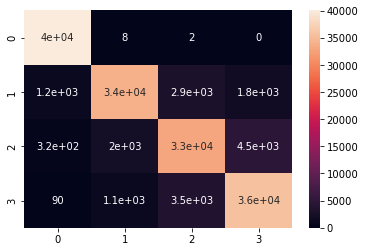

In [63]:
sns.heatmap(cf_matrix, annot=True)